# 银行股增长率对比

In [64]:
suppressMessages({
library(tidyverse)
library(ggrepel)
library(showtext)
font.add("simhei", "/mnt/c/Windows/Fonts/simhei.ttf") # 支持中文字体
showtext.auto()
})

In [39]:
# 初始化API

suppressMessages(library(Tushare))
token = readLines("token.txt")
api = Tushare::pro_api(token)

In [43]:
# 获取股票列表，并从中筛选出所有银行股

stock_list = suppressWarnings(api(api_name = "stock_basic"))
bank_stock_list = stock_list %>% filter(industry == "银行")

In [50]:
# 获取所有银行股的资产负债表

bank_balance_sheet = lapply(bank_stock_list$ts_code, function(ts_code) {
    suppressWarnings(api(api_name = "balancesheet", ts_code = ts_code))
  }) %>%
  do.call("rbind", .)

In [93]:
# 筛选并排序净资产信息

bank_net_asset = bank_balance_sheet %>%
  mutate(net_asset = total_hldr_eqy_inc_min_int / 1e8,
         year = as.integer(substr(end_date, 1, 4))) %>%
  distinct(ts_code, year, end_date, end_type, net_asset) %>%
  na.omit() %>%
  arrange(ts_code, end_date, end_type) %>%
  left_join(bank_stock_list, by = "ts_code") %>%
  mutate(display_name = sprintf("%s(%s)", name, ts_code))

bank_net_asset_yearly = bank_net_asset %>%
  group_by(display_name, name, ts_code, year) %>%
  filter(year < 2023) %>%
  summarize(net_asset = sum(net_asset), .groups = "keep")

Warning message:
“Removed 699 rows containing missing values (`geom_label_repel()`).”
Warning message:
“ggrepel: 16 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


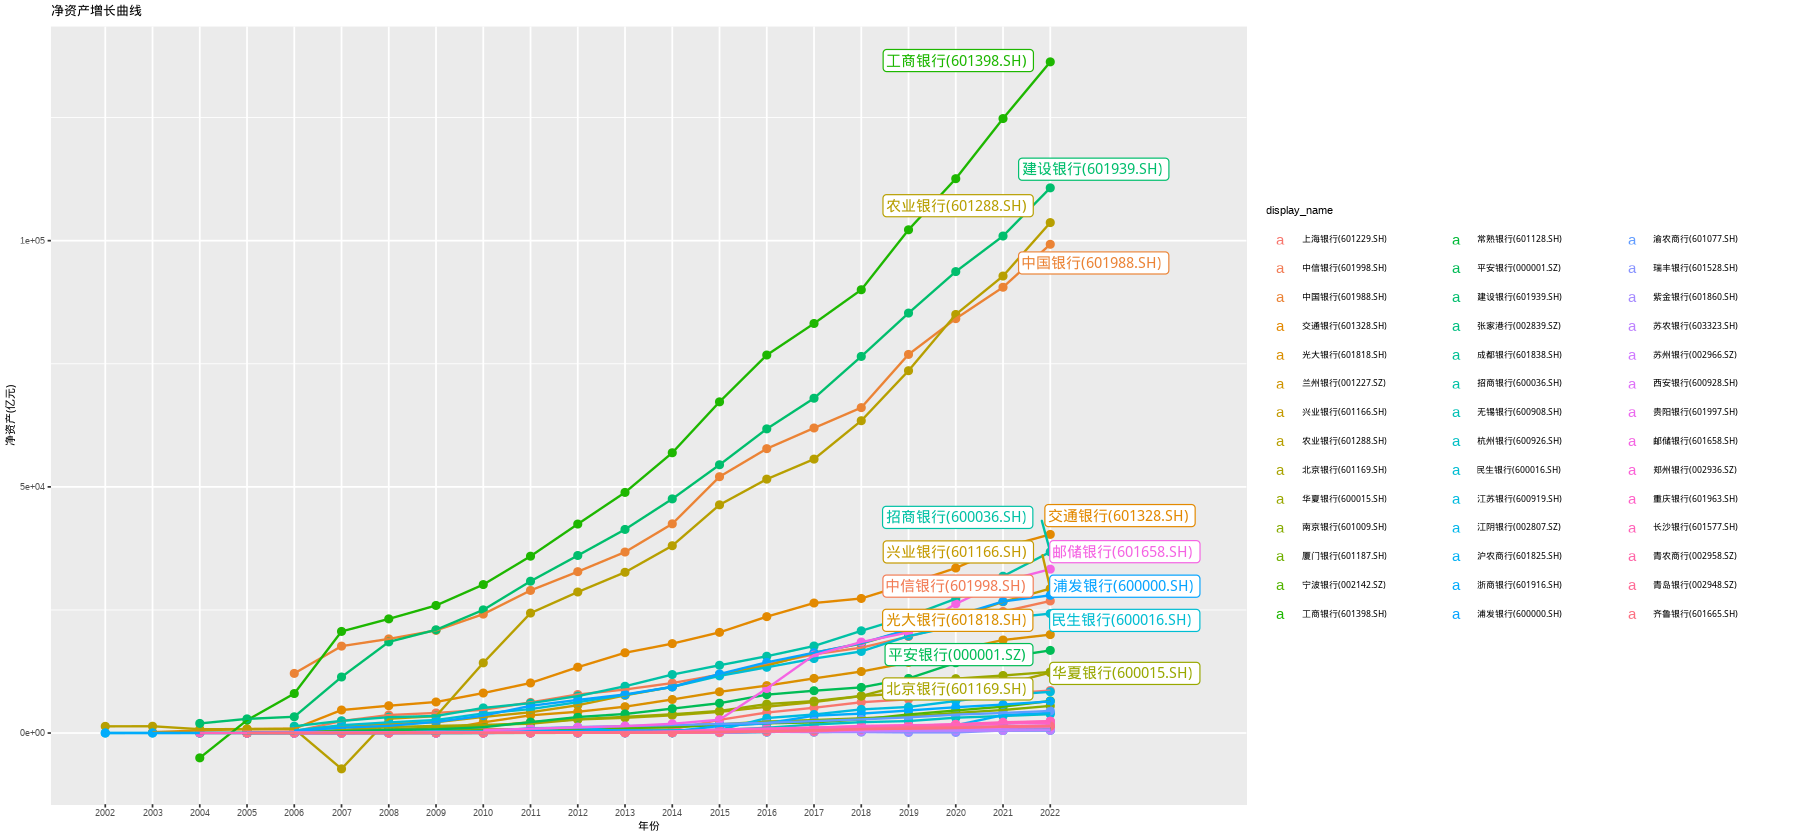

In [97]:
options(repr.plot.width = 15, repr.plot.height = 7)

bank_net_asset_yearly %>%
  mutate(display_label = ifelse(year == 2022 & net_asset > 2000, display_name, NA)) %>%
  ggplot(aes(x = year, y = net_asset, group = display_name, color = display_name)) +
  geom_point() +
  geom_line() +
  geom_label_repel(aes(label = display_label, hjust = 0)) +
  scale_x_continuous(limits = c(2002, 2025), breaks = 2002:2022, minor_breaks = NULL) +
  ggtitle("净资产增长曲线") +
  labs(x = "年份", y = "净资产(亿元)") +
  theme_gray(base_size = 8)

In [109]:
# 计算净资产年增长率

bank_net_asset_yearly_growth = bank_net_asset_yearly %>%
  filter(net_asset > 0) %>%
  group_by(display_name, name, ts_code) %>%
  arrange(year) %>%
  mutate(net_asset_inc = c(NA, diff(net_asset))) %>%
  ungroup() %>%
  arrange(display_name, name, ts_code, year) %>%
  mutate(net_asset_growth_rate = net_asset_inc / (net_asset - net_asset_inc)) %>%
  na.omit()

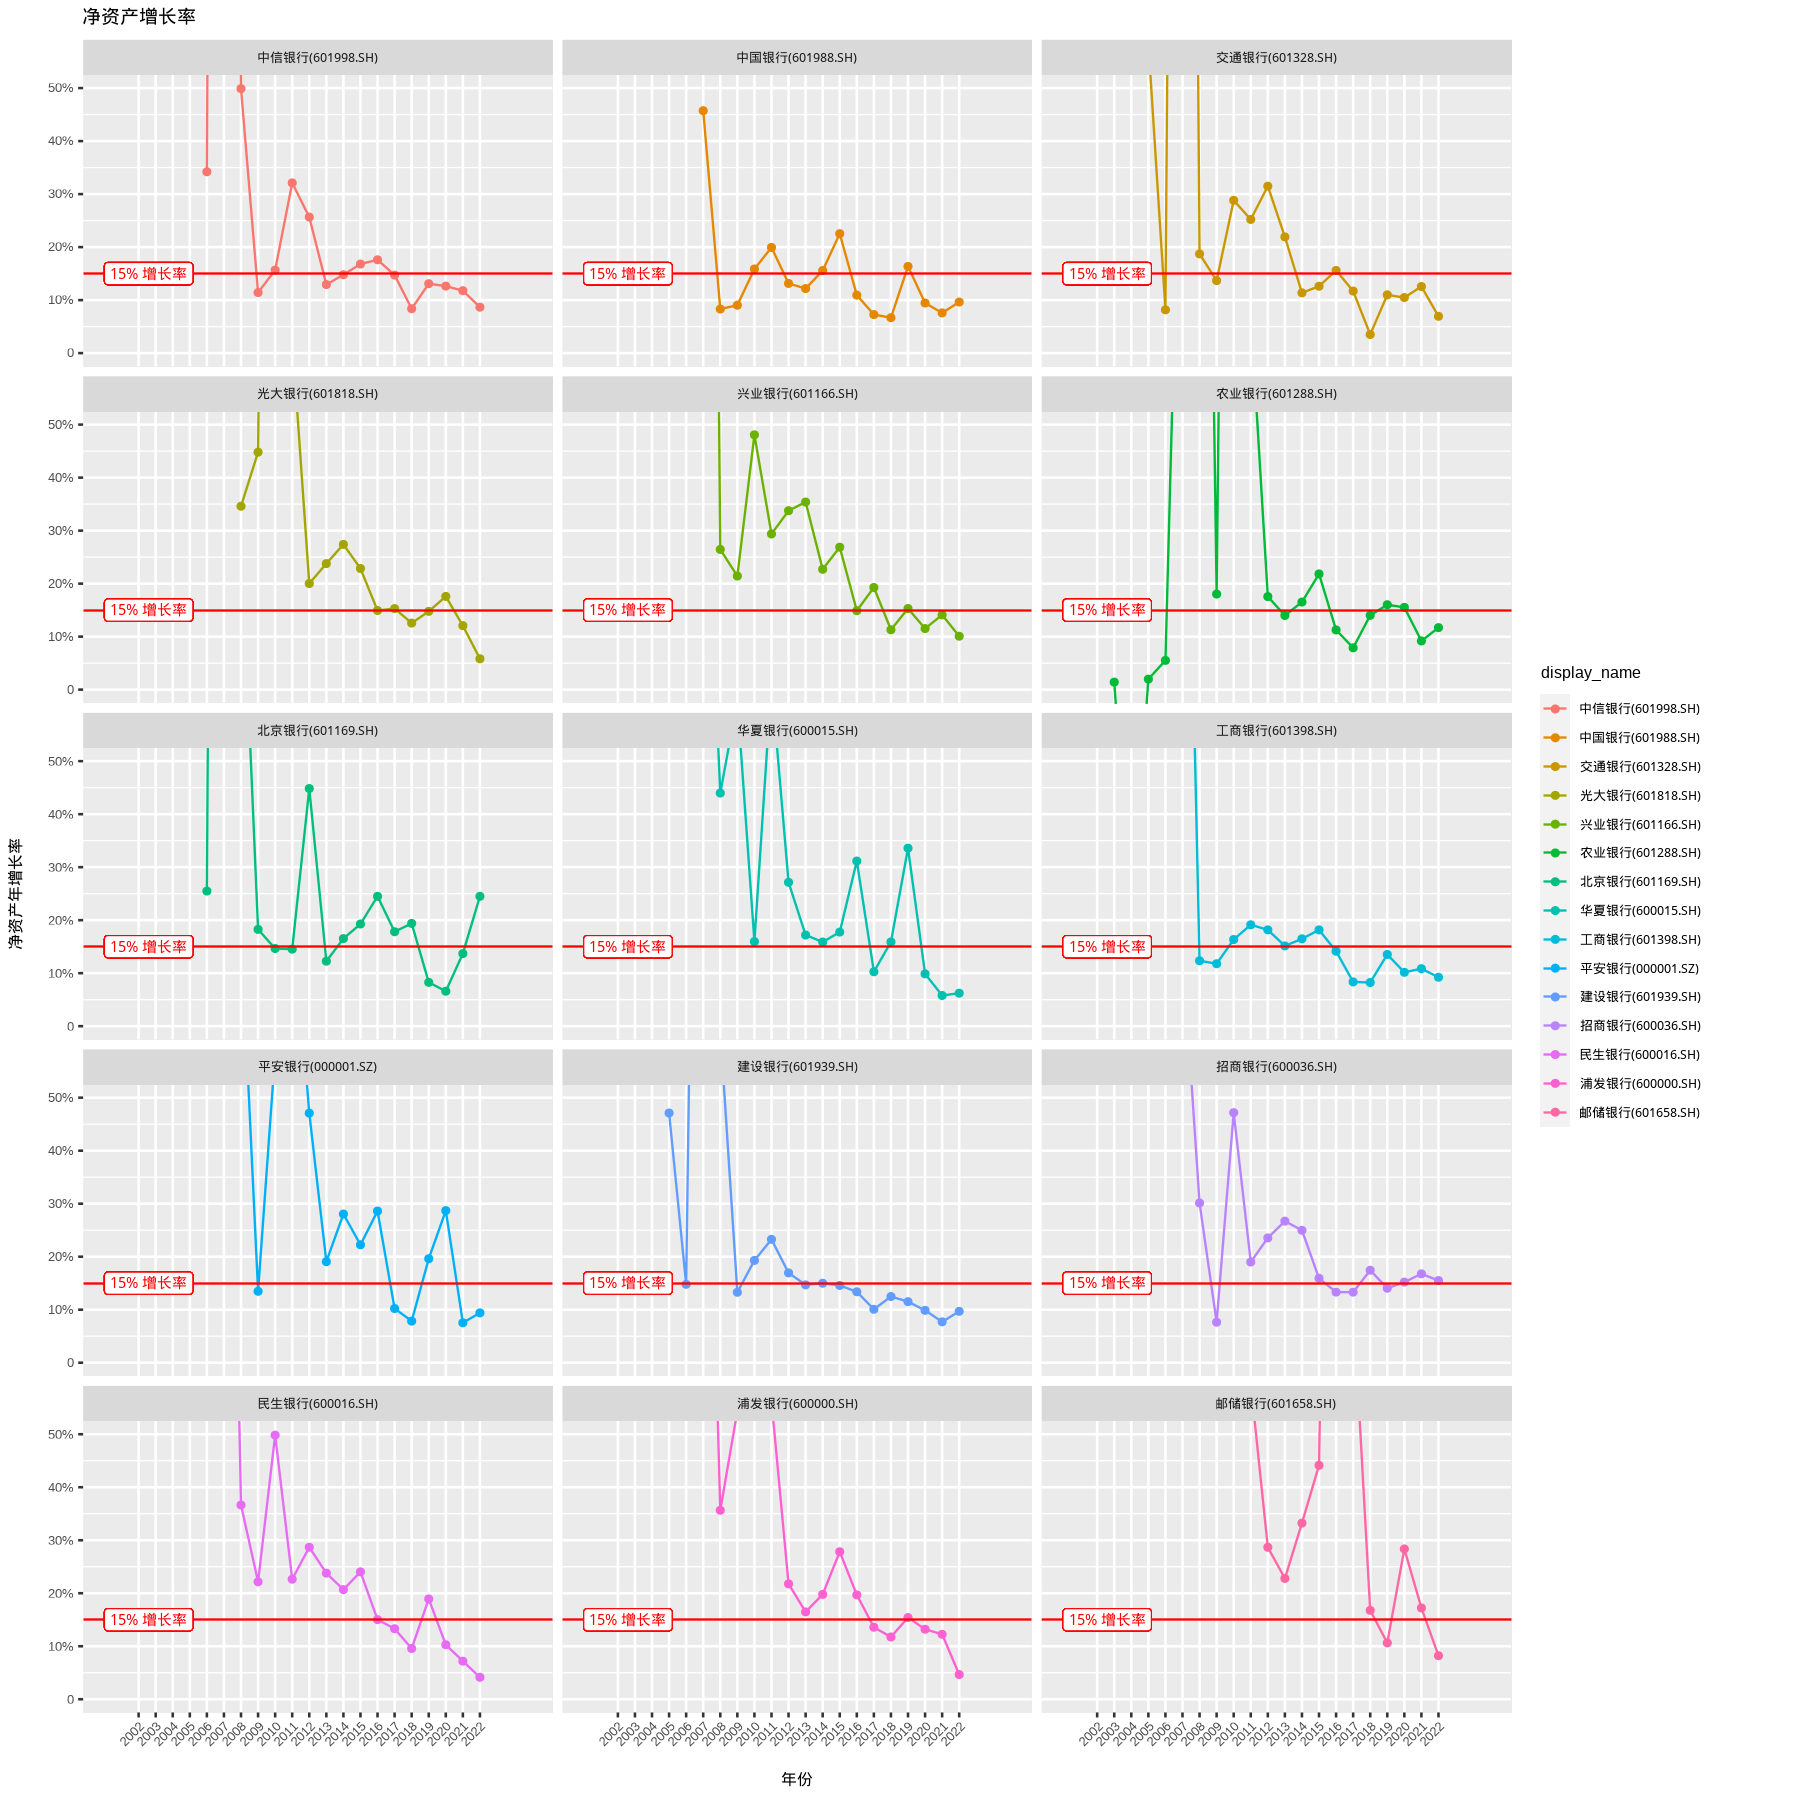

In [129]:
options(repr.plot.width = 15, repr.plot.height = 15)

bank_net_asset_yearly_growth %>%
  filter(name %in% c("中国银行", "工商银行", "农业银行", "建设银行", "交通银行",
                     "邮储银行", "招商银行", "浦发银行", "兴业银行", "中信银行",
                     "民生银行", "平安银行", "华夏银行", "北京银行", "光大银行")) %>%
  ggplot(aes(x = year, y = net_asset_growth_rate, group = display_name, color = display_name)) +
  geom_point() +
  geom_line() +
  scale_x_continuous(limits = c(2000, 2025), breaks = 2002:2022, minor_breaks = NULL) +
  scale_y_continuous(breaks = seq(0, 0.5, by = 0.1), labels = c("0", "10%", "20%", "30%", "40%", "50%")) +
  coord_cartesian(ylim = c(0, 0.5)) +
#  scale_y_continuous(limits = c(0, 1)) +
  facet_wrap(~ display_name, ncol = 3) +
  ggtitle("净资产增长率") +
  labs(x = "年份", y = "净资产年增长率") +
  theme_gray(base_size = 12) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  geom_hline(yintercept = 0.15, color = "red") +
  geom_label(x = 2000, y = 0.15, label = "15% 增长率", color = "red", hjust = 0)

In [131]:
# 获取股价

#api(api_name = 'daily', ts_code = "000001.SZ", start_date = "20181001", end_date = "20181010")

In [130]:
# 获取股息派发信息

#df3 = api(api_name = "dividend", ts_code="600036.SH")